In [1]:
!pip install tensorflow_ranking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.5 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existin

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn

import pickle

In [9]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [10]:
file_name = "windowed_raw" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")


#times_to_add = 8

#x_data = np.concatenate([x_data] + [x_data + np.random.normal(0,0.1,x_data.shape) for i in range(times_to_add)])
#y_intent = np.concatenate([y_intent] + [y_intent for i in range(times_to_add)])

In [11]:
x_data.shape

(34371, 200, 16)

## Auth model

In [12]:
def get_auth_model(input_dim):
    inputs = keras.Input(shape=input_dim)
    x = inputs
    x = Reshape((200, 16, 1))(x)
    x = Conv2D(10,(3, 1), strides=(1,1), padding="same")(x)
    x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)

    x = Conv2D(100,(2,16),strides=(1,1))(x)

    x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)
    x = Permute((1,3,2))(x)
    print(x)
    x = Reshape((50,100))(x)

    x = layers.SpatialDropout1D(0.2)(x)
    x = Conv1D(50, 4, strides=2, padding="same")(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)

    x = layers.SpatialDropout1D(0.2)(x)
    x = Conv1D(50, 4, strides=2, padding="same")(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    print(x)
    x = Flatten()(x)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="LSTM_classifier")
    return model

model = get_auth_model(x_data.shape[1:])
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy", "mse"])
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 100, 1), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='max_pooling1d_1/Squeeze:0', description="created by layer 'max_pooling1d_1'")
Model: "LSTM_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 16)]         0         
                                                                 
 reshape (Reshape)           (None, 200, 16, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 200, 16, 10)       40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 16, 10)      0         
 )                                                    

## VAE with multiple outputs from latent space

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, _classifier = None, _auth = None, beta = 0.001, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.classifier = _classifier
        self.auth = _auth
        #self.classifier = keras.models.load_model(f'data/models/{model_name}.hdf5')

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.feature_loss_tracker = keras.metrics.Mean(
            name="feature_loss"
        )
        self.classification_loss_tracker = keras.metrics.Mean(
            name="classification_loss"
        )
        self.reencoding_loss_tracker = keras.metrics.Mean(
            name="reencoding_loss"
        )
        self.auth_loss_tracker = keras.metrics.Mean(name="auth_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.beta = beta

    def save_model(self, folder, tag):
        
        with open(f'data/models/{folder}/enc_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.encoder, f)

        with open(f'data/models/{folder}/dec_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.decoder, f)

        with open(f'data/models/{folder}/auth_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.auth, f)
    
    def load_model(self, folder, tag):
        
        with tf.keras.utils.custom_object_scope({'Sampling': Sampling}):
            with open(f'data/models/{folder}/enc_{tag}.pickle', 'rb') as pickle_file:
                self.encoder = pickle.load(pickle_file)
            with open(f'data/models/{folder}/dec_{tag}.pickle', 'rb') as pickle_file:
                self.decoder = pickle.load(pickle_file)
            with open(f'data/models/{folder}/auth_{tag}.pickle', 'rb') as pickle_file:
                self.auth = pickle.load(pickle_file)
        
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.feature_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data, y_user_one_hot = data
        print(data)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            #data_probability = self.classifier(data)
            #reconstruction_probability = self.classifier(reconstruction)
            #classification_loss = tf.reduce_mean(abs(data_probability - reconstruction_probability))

            reconstruction_loss = tf.reduce_mean(keras.losses.mse(data, reconstruction), axis=1) # * data_probability
            
            #re_encoded, _, _ = self.encoder(reconstruction)
            #reencoding_loss = tf.reduce_mean(keras.losses.mse(z_mean, re_encoded))
            
            #feature_loss = tf.reduce_mean(keras.losses.MeanAbsolutePercentageError(self.batch_features(data), self.batch_features(reconstruction)))
            
            feature_loss = 0.5 * (tf.reduce_mean(keras.losses.mse(self.rolling_max(data), self.rolling_max(reconstruction))) + 
                                          tf.reduce_mean(keras.losses.mse(self.rolling_min(data), self.rolling_min(reconstruction))) )

            #reconstruction_loss = tf.reduce_mean(keras.losses.mean_absolute_error(data, reconstruction), axis=1)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            auth_output = self.auth(z)
            
            auth_loss = tfr.keras.losses.ApproxMRRLoss()(y_user_one_hot, auth_output) ## TODO - figure out how to get true values in here

            sample_loss = 0.5 * reconstruction_loss + 0.5 * feature_loss #+ 0.0 * feature_loss
            
            total_loss = auth_loss + sample_loss + self.beta * kl_loss #+ classification_loss # + 0.1*feature_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.auth_loss_tracker.update_state(auth_loss)
        #self.feature_loss_tracker.update_state(feature_loss)
        #self.reencoding_loss_tracker.update_state(reencoding_loss)
        #self.classification_loss_tracker.update_state(classification_loss) #
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "feature_loss"       : self.feature_loss_tracker.result(),
            "auth_loss": self.auth_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def batch_features(self, x):
        feature_list = []
        #_max = tf.math.reduce_max(x, axis=1)
        #_min = tf.math.reduce_min(x, axis=1)
        _segment_max = self.rolling_max(x)
        _segment_min = self.rolling_min(x)
        _range = _segment_max - _segment_min
        
        _mean = tf.math.reduce_mean(_range, axis=0)
        _std = tf.math.reduce_std(_range, axis=0)
        
        return [ _mean, _std] # _max, _min,


    def rolling_max(self, x):
        return tf.nn.pool(
            x,
            (5,),
            "MAX",
            strides=(1,),
            padding='VALID'
        )
    
    def rolling_min(self, x):
        return -tf.nn.pool(
            -x,
            (5,),
            "MAX",
            strides=(1,),
            padding='VALID'
        )
        
    def rolling_mean(self, x):
        return tf.nn.pool(
            x,
            (5,),
            "MEAN",
            strides=(5,),
            padding='VALID'
        )
        

In [15]:
latent_dim = 200

input_dim = x_data.shape[1:]

inputs = keras.Input(shape=input_dim)

x = inputs
x = Reshape((200, 16, 1))(x)
x = Conv2D(10, (3, 1), kernel_regularizer=l2(0.01), strides=(1,1), padding="same")(x)
x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)

x = Conv2D(100,(2,16), kernel_regularizer=l1(0.01), strides=(1,1))(x)

x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)
x = Permute((1,3,2))(x)
x = Reshape((50,100))(x)

x = layers.SpatialDropout1D(0.2)(x)
x = Conv1D(50, 4, strides=2, padding="same")(x)
x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)

x = layers.SpatialDropout1D(0.2)(x)
x = Conv1D(50, 4, strides=2, padding="same")(x)

x = LSTM(latent_dim)(x)

z_mean = layers.Dense(latent_dim, name="z_mean" )(x) # kernel_initializer=keras.initializers.Zeros()
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer=keras.initializers.Zeros())(x)

## TODO add in dropout here

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 16)]    0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 200, 16, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 200, 16, 10)  40          ['reshape_2[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 100, 16, 10)  0          ['conv2d_2[0][0]']               
                                                                                            

In [16]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = latent_inputs


latent_inputs = keras.Input(shape=(latent_dim,))
x = latent_inputs
#x = layers.Dropout(rate=0.2)(x)
#x = layers.Reshape((latent_dim))(x)
x = layers.RepeatVector(25)(x)
#x = layers.Permute((2,1))(x)
print(x)

x = layers.LSTM(100, activation="relu", input_shape=(25,latent_dim), return_sequences=True)(x)

print(x)

x = layers.TimeDistributed(layers.Dense(100, activation="relu"))(x)
x = layers.TimeDistributed(layers.Dense(16))(x)

print(x)

x = layers.Conv1D(16,4, padding="same")(x)
x = layers.UpSampling1D(size=2)(x)
x = layers.Conv1D(16,4, padding="same")(x)
x = layers.UpSampling1D(size=2)(x)
x = layers.Conv1D(16,8, padding="same")(x)
x = layers.UpSampling1D(size=2)(x)
x = layers.Conv1D(16,8, padding="same")(x)

x2 = layers.RepeatVector(25)(latent_inputs)

decoder_outputs = x

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 200), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")
KerasTensor(type_spec=TensorSpec(shape=(None, 25, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 25, 16), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 repeat_vector (RepeatVector  (None, 25, 200)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)           

In [17]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = latent_inputs
x = layers.Dense(25, activation="relu")(x)
x = layers.Dense(16, activation="softmax")(x)

auth_outputs = x

auth = keras.Model(latent_inputs, auth_outputs, name="auth")
auth.summary()

#

Model: "auth"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_5 (Dense)             (None, 25)                5025      
                                                                 
 dense_6 (Dense)             (None, 16)                416       
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [18]:
#sample_weights = np.array([class_weights[i] for i in y_intent[:len(y_gesture)]])
#print(sample_weights)

In [19]:
#np.unique(sample_weights, return_counts=1)

In [20]:
N = len(y_gesture)

unweighted_data = x_data[:N]
weighted_data = np.concatenate([unweighted_data] + [unweighted_data[(y_intent == 1)[:N]] for i in range(20)])
weighted_y_data = np.concatenate([y_user] + [y_user[(y_intent == 1)[:N]] for i in range(20)])

vae = VAE(encoder, decoder, classifier, auth)
#opt = keras.optimizers.Adam()



In [21]:
auth_user = 15

auth_gesture_map = (y_intent == 1) & (y_user.argmax(axis=1) == auth_user)

non_auth_user_map = (y_user.argmax(axis=1) != auth_user)


total_auth_gestures = sum(auth_gesture_map)

# test mapping is the last third of gestures
final_third = int(total_auth_gestures * (2/3))


non_auth_user_data = x_data[non_auth_user_map]

# train basic model for reconstruction

vae = VAE(encoder, decoder, classifier, auth)
opt = keras.optimizers.Adam()

vae.compile(optimizer=opt)
vae.beta = 0.000001
history_1 = vae.fit(x_data[non_auth_user_map], y_user[non_auth_user_map], epochs=10, batch_size=128)

vae.save_model("no_15", "basic_reconstruction")

# don't train auth here


Epoch 1/10
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
267/267 [==============================] - 39s 87ms/step - loss: 812.1470 - reconstruction_loss: 724.7347 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.3143 - kl_loss: 174.8401
Epoch 2/10
267/267 [==============================] - 22s 84ms/step - loss: 642.4946 - reconstruction_loss: 617.0899 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.4146 - kl_loss: 327.0005
Epoch 3/10
130/267 [=============>................] - ETA: 11s - loss: 487.5084 - reconstruction_loss: 511.9041 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.4313 - kl_loss: 388.5197

KeyboardInterrupt: 

In [ ]:

train_auth_gesture_data = x_data[auth_gesture_map][:final_third]

for i in range(1):
    perc = (i+1) / 5
    
    
    restricted_train_auth_gesture_data = train_auth_gesture_data[:int(perc*len(train_auth_gesture_data))]
    print(f"Training with {len(restricted_train_auth_gesture_data)} actual auth gestures.")
    
    auth_weighted_data = np.concatenate([x_data[(y_intent == 1) & non_auth_user_map]] + [restricted_train_auth_gesture_data for j in range(20)])
    auth_weighted_data_y = np.concatenate([y_user[(y_intent == 1) & non_auth_user_map]] + [np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1] for k in range(len(restricted_train_auth_gesture_data))]) for j in range(20)])
    
    vae = VAE(None, None, None)
    vae.load_model("no_15", "basic_reconstruction")
    
    beta = 0.00001

    epochs = 10

    vae.beta = beta
    vae.compile(keras.optimizers.Adam())

    vae.fit(auth_weighted_data, auth_weighted_data_y, epochs=100, batch_size=128)

    for epoch in range(epochs):
        beta_star = beta / np.exp(-epoch * np.log(100) / epochs)
        print(epoch, beta_star)
        vae.beta = beta_star
        vae.compile(optimizer = keras.optimizers.Adam())

        vae.fit(auth_weighted_data, auth_weighted_data_y, epochs=30, batch_size=128)

    
    vae.save_model("no_15", f"{perc}_data")




Training with 33 actual auth gestures.
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-15 14:55:00           64
config.json                                    2023-01-15 14:55:00         7127
variables.h5                                   2023-01-15 14:55:00      1417096
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......max_pooling2d
.........

In [55]:
vae.compile(optimizer=opt)
vae.beta = 0.000001
history_1 = vae.fit(weighted_auth_data, weighted_y_auth_data, epochs=10, batch_size=128)



Epoch 1/10
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
772/772 [==============================] - 61s 68ms/step - loss: -0.3975 - reconstruction_loss: 0.2812 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6805 - kl_loss: 738.0255
Epoch 2/10
772/772 [==============================] - 52s 67ms/step - loss: -0.4728 - reconstruction_loss: 0.2693 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7139 - kl_loss: 766.2676
Epoch 3/10
772/772 [==============================] - 52s 67ms/step - loss: -0.4996 - reconstruction_loss: 0.2613 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7314 - kl_loss: 774.7724
Epoch 4/10
772/772 [==============================] - 52s 67ms/step - loss: -0.5159 - reconstruction_loss: 0.2538 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7415 - kl_loss: 789.2784
Epoc

In [56]:
vae.save_model("no_15", "all_data")


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......permute
.........vars
......reshape
.........vars
......reshape_1
.........vars
......sampling
.........vars
......spatial_dropout1d
.........vars
......spatial_dropout1d_1
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                         

In [20]:
vae = VAE(None, None, None)
vae.load_model("no_15", "all_data")


Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2022-11-30 09:54:24           64
config.json                                    2022-11-30 09:54:24         7121
variables.h5                                   2022-11-30 09:54:24      1417096
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........var

In [60]:
gesture_data = unweighted_data[auth_map] # y_intent == 1

beta = 0.00001

epochs = 10

vae.beta = beta
vae.compile(keras.optimizers.Adam())

vae.fit(gesture_data, y_user[auth_map], epochs=100, batch_size=128)

for epoch in range(epochs):
    beta_star = beta / np.exp(-epoch * np.log(100) / epochs)
    print(epoch, beta_star)
    vae.beta = beta_star
    vae.compile(optimizer = keras.optimizers.Adam())
    
    vae.fit(gesture_data, y_user[auth_map], epochs=30, batch_size=128)

Epoch 1/100
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
26/26 [==============================] - 11s 67ms/step - loss: -0.6266 - reconstruction_loss: 0.1521 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7992 - kl_loss: 574.6127
Epoch 2/100
26/26 [==============================] - 2s 67ms/step - loss: -0.6704 - reconstruction_loss: 0.1287 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7992 - kl_loss: 576.0877
Epoch 3/100
26/26 [==============================] - 2s 68ms/step - loss: -0.6675 - reconstruction_loss: 0.1248 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7993 - kl_loss: 573.7250
Epoch 4/100
26/26 [==============================] - 2s 66ms/step - loss: -0.6720 - reconstruction_loss: 0.1236 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7993 - kl_loss: 576.3431
Epoch 5/100

In [62]:
vae.save_model("no_15", "incr_beta")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......permute
.........vars
......reshape
.........vars
......reshape_1
.........vars
......sampling
.........vars
......spatial_dropout1d
.........vars
......spatial_dropout1d_1
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                         

In [234]:
vae.beta = 0.001
vae.compile(optimizer = keras.optimizers.Adam(lr = 0.0001))
history_3 = vae.fit(unweighted_data[(y_intent == 1)[:N]], epochs=100, batch_size=128)

Epoch 1/100


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
28/28 [==============================] - 10s 60ms/step - loss: 0.7485 - reconstruction_loss: 0.2258 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - kl_loss: 477.6158
Epoch 2/100
28/28 [==============================] - 2s 61ms/step - loss: 0.5732 - reconstruction_loss: 0.2621 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - kl_loss: 277.4167
Epoch 3/100
28/28 [==============================] - 2s 63ms/step - loss: 0.4702 - reconstruction_loss: 0.3188 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - kl_loss: 140.0166
Epoch 4/100
28/28 [==============================] - 2s 66ms/step - loss: 0.4365 - reconstruction_loss: 0.3275 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - kl_loss: 105.7513
Epoch 5/100
28/28 [==============================] - 2s 64ms/step - loss: 0.4230 - reconstruction_loss: 0.3264 

In [ ]:
opt.iterations

NameError: name 'history_2' is not defined

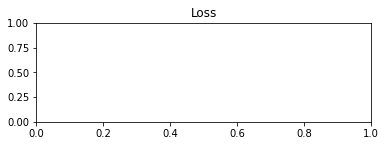

In [63]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history_2.history['kl_loss'], label='kl_loss')
plt.plot(np.array(history_2.history['reconstruction_loss'])*5, label='reconstruction')
plt.legend()
plt.show()

In [21]:
classifier(vae.decoder.predict(vae.encoder.predict(x_data[:1])[0]))

1/1 [==============================] - 0s 393ms/step


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.996741]], dtype=float32)>

In [22]:
pca = PCA(20)
total_z_mean, _, _ = vae.encoder.predict(x_data[auth_map])
total_z_pca = pca.fit_transform(total_z_mean)

102/102 [==============================] - 0s 3ms/step


In [23]:
from sklearn.manifold import TSNE
import pandas as pd

def dimension_reduction(z_pca, labels) -> pd.DataFrame:

  visualisation = TSNE(n_components=2).fit_transform(z_pca)
  df = pd.DataFrame(visualisation, columns = ["dimension 1", "dimension 2"])  #, "dimension 3"
  df["labels"] = labels
  return df

In [24]:
def plot_label_clusters(vae, data, labels, pca=None):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    if pca is None:
        pca = PCA()
        z_pca = pca.fit_transform(z_mean)
        #z_pca = z_mean
    else:
        z_pca = pca.transform(z_mean)
    
    comps = 5
    
    #z_pca = z_mean

    pair_set = [(i,j) for i in range(comps) for j in range(i+1,comps)]
    
    fig, ax = plt.subplots(1 + len(pair_set)//3,3, figsize=(24,48))
    
    for ix, (i,j) in enumerate(pair_set):
        scatter = ax[divmod(ix, 3)].scatter(z_pca[:, i], z_pca[:, j], c=labels, alpha=0.7, cmap = "rainbow")
        ax[divmod(ix, 3)].set_xlabel(f"z[{i}]")
        ax[divmod(ix, 3)].set_ylabel(f"z[{j}]")
        legend = ax[divmod(ix, 3)].legend(*scatter.legend_elements(),
                    loc="upper right", title="Users")
        ax[divmod(ix, 3)].add_artist(legend)
    #plt.colorbar()
    
    plt.show()

def visualise(vae, data, labels, pca=None):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    if pca is None:
        pca = PCA(20)
        z_pca = pca.fit_transform(z_mean)
        #z_pca = z_mean
    else:
        z_pca = pca.transform(z_mean)
    
    df = dimension_reduction(z_pca, labels)

    fig, ax = plt.subplots(1,1, figsize=(24,12) ) # , subplot_kw={"projection": "3d"})# , 
                           
    ax.scatter(df["dimension 1"], df["dimension 2"],  c = df["labels"], cmap = "rainbow") #  df["dimension 3"],
    ax.set_xlabel("z[{i}]")
    ax.set_ylabel("z[{j}]")
    #plt.colorbar()
    
    plt.show()

    
# [:len(y_gesture)]
    
intent_x = np.array(list(x_data[:1000])+list(x_data[-1000:]))
intent_y = np.array(list(y_intent[:1000]) + list(y_intent[-1000:]))

gesture_x = x_data[:600]
gesture_y = y_gesture.argmax(axis=1)[:600]

_map = (y_intent == 1) & ((y_user.argmax(axis=1) == 13) | (y_user.argmax(axis=1) == 14) | (y_user.argmax(axis=1) == 15))

user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]




23/23 [==============================] - 0s 5ms/step


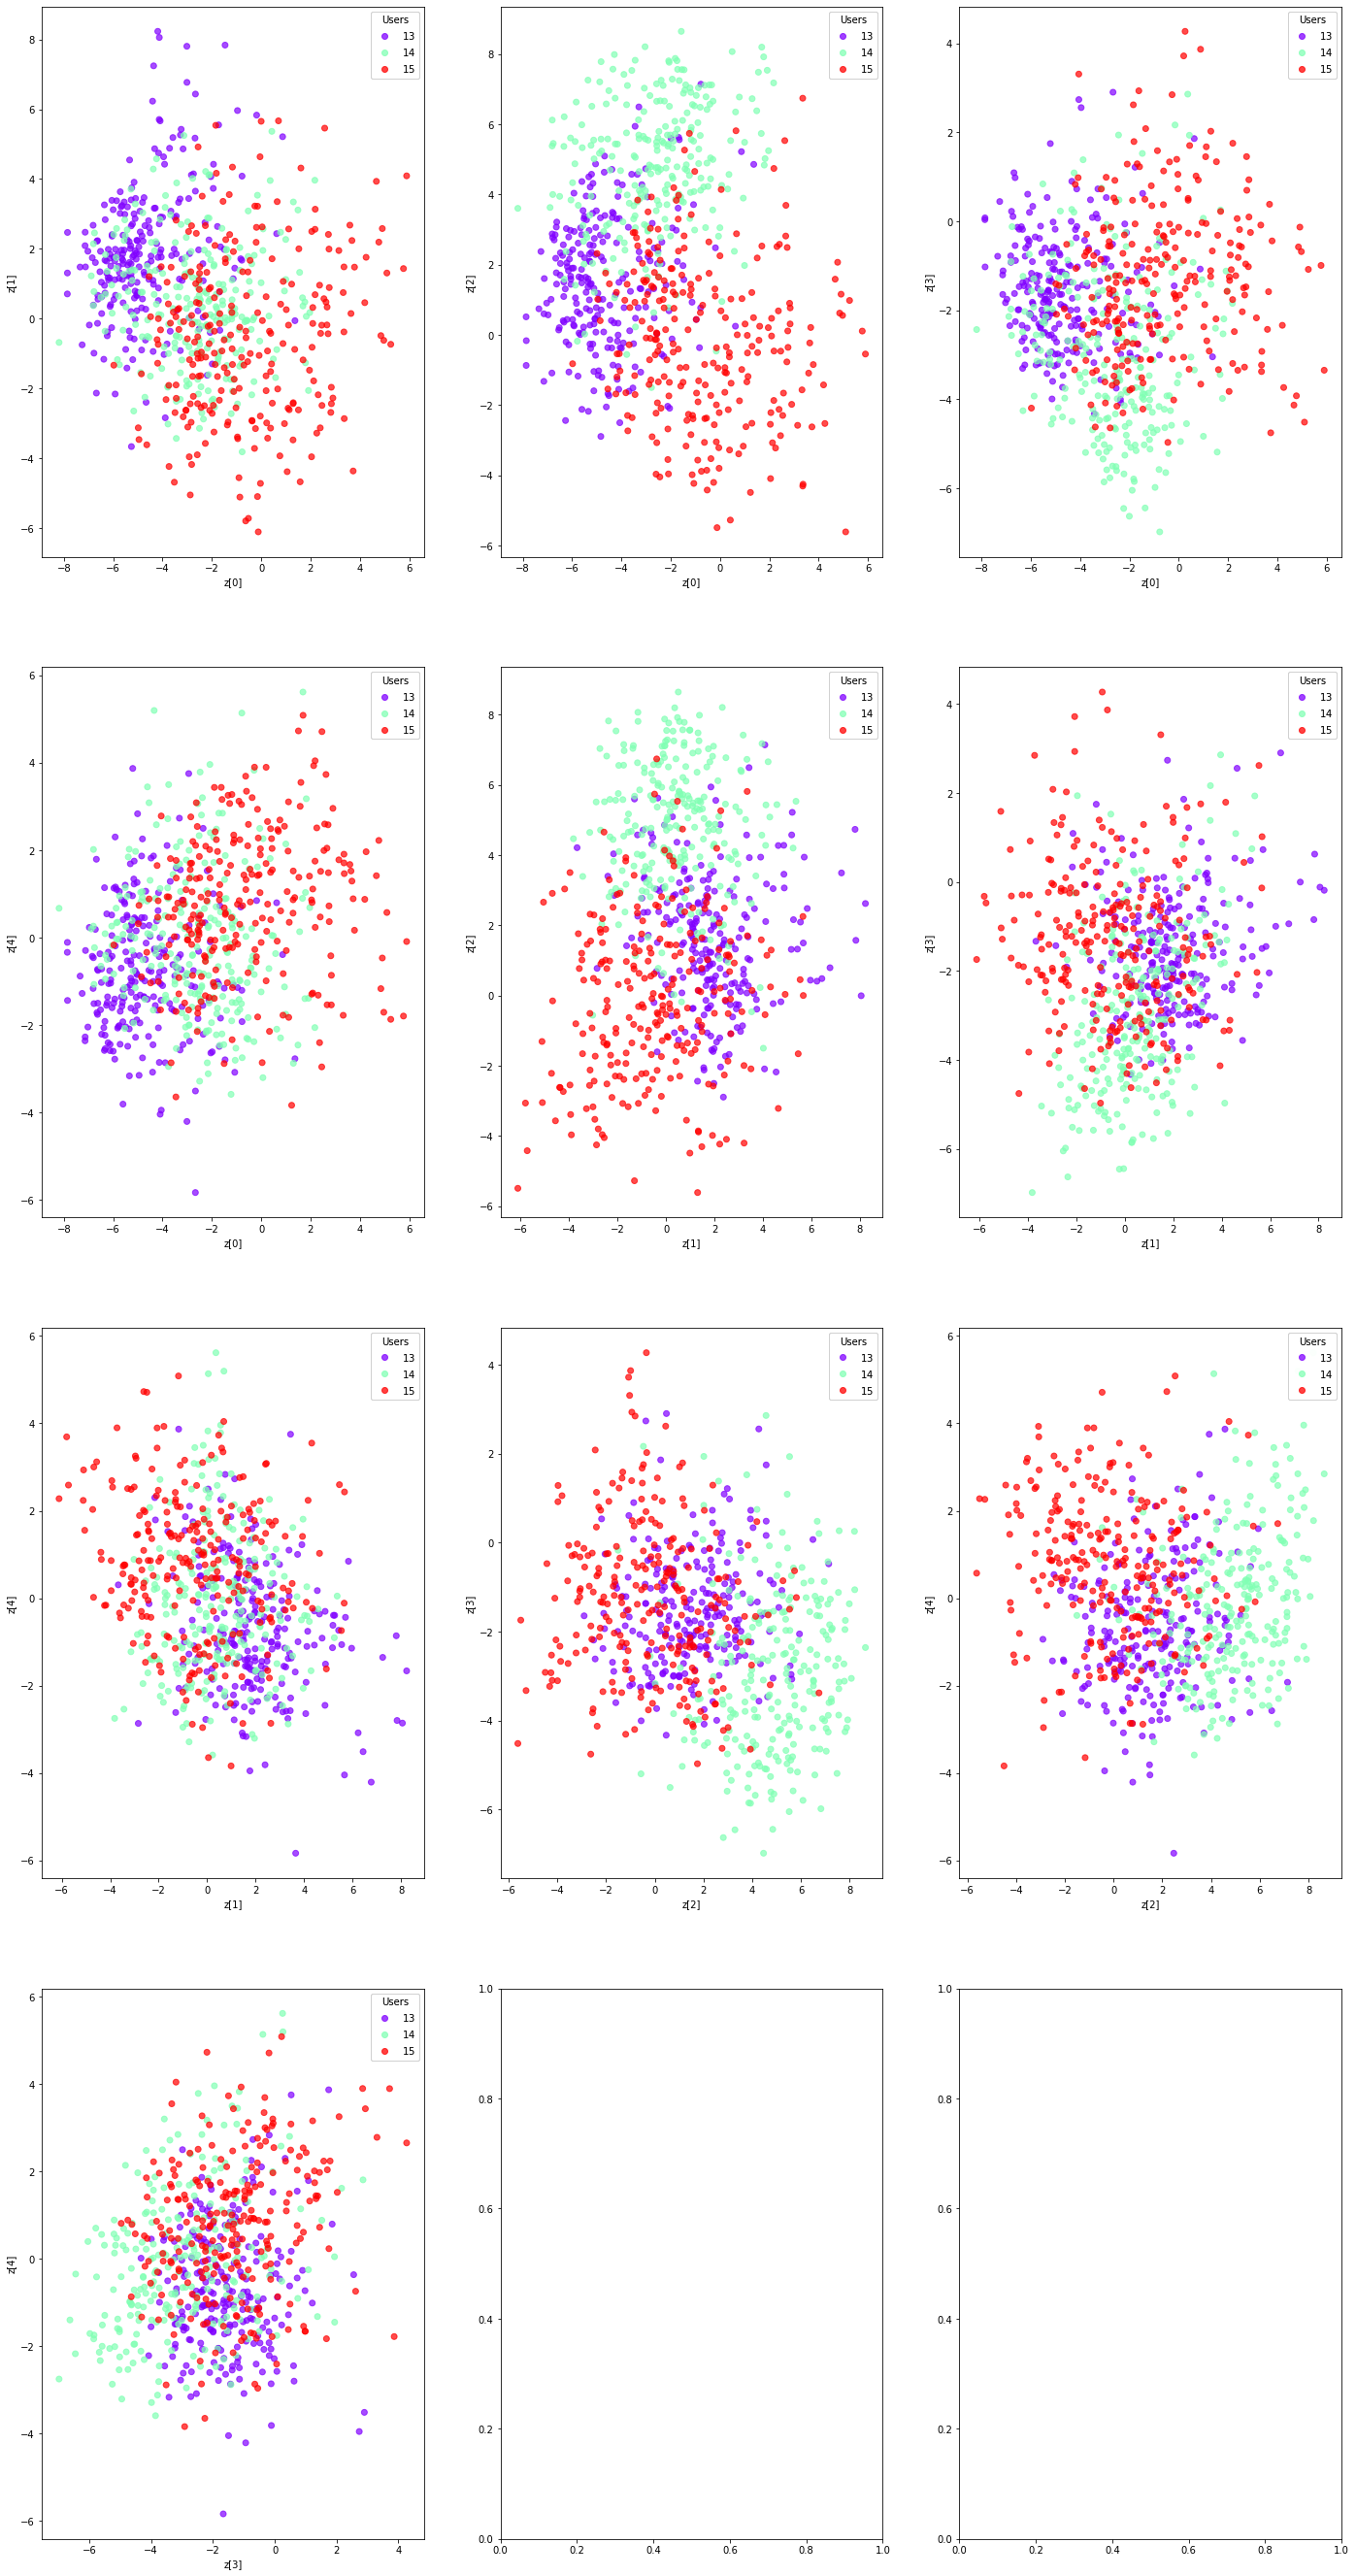

23/23 [==============================] - 0s 4ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


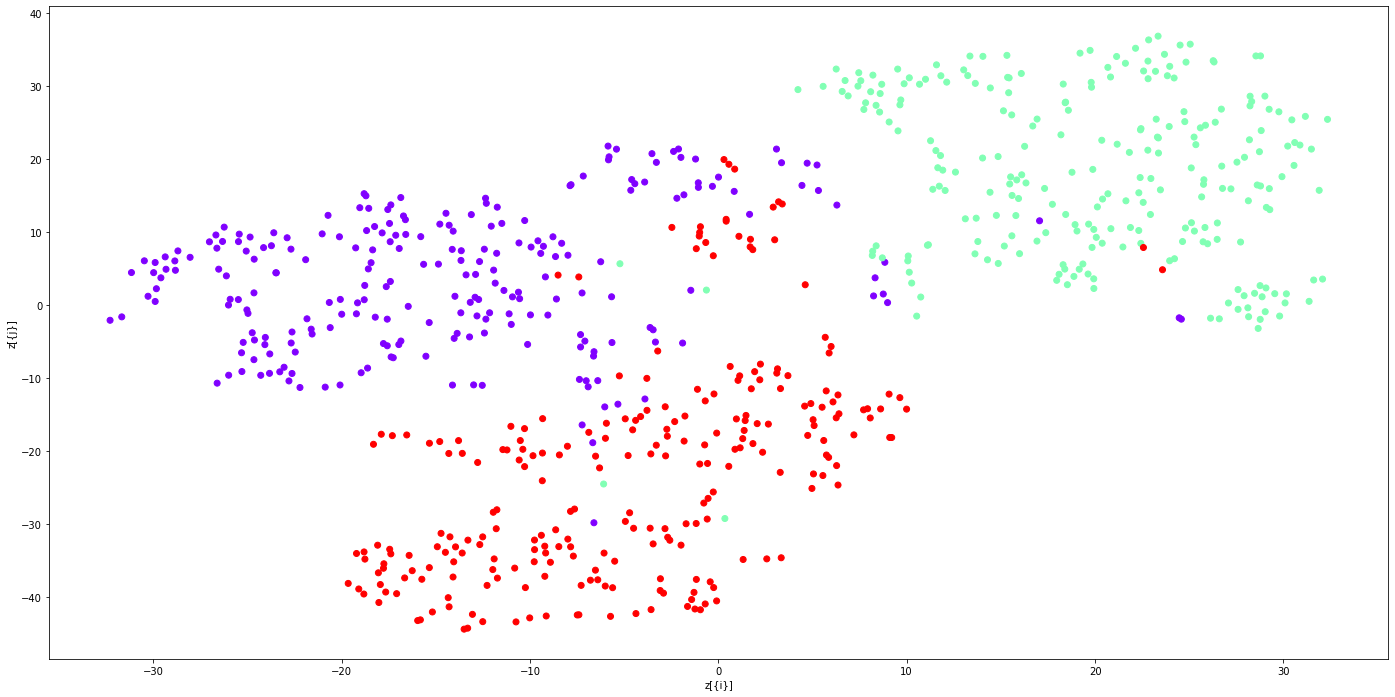

In [25]:
#plot_label_clusters(vae, intent_x, intent_y, pca)
plot_label_clusters(vae, user_x, user_y, pca)
#plot_label_clusters(vae, gesture_x, gesture_y, pca)

visualise(vae, user_x, user_y, pca)
#visualise(vae, intent_x, intent_y)
#visualise(vae, gesture_x, gesture_y, pca)

In [26]:
np.unique(y_intent[:len(y_gesture)], return_counts=True)

(array([0, 1], dtype=int32), array([30771,  3484]))

In [27]:
data  = tf.constant([[[1.0, 8.0], [3.0, 4.0], [5, 6], [7, 8], [9, 10], [11,12]]])  # shape is (time, channels)

tf.nn.pool(
    data,
    (3,),
    "MAX",
    strides=(3,),
    padding='VALID'
)

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[ 5.,  8.],
        [11., 12.]]], dtype=float32)>

1/1 [==============================] - 0s 29ms/step


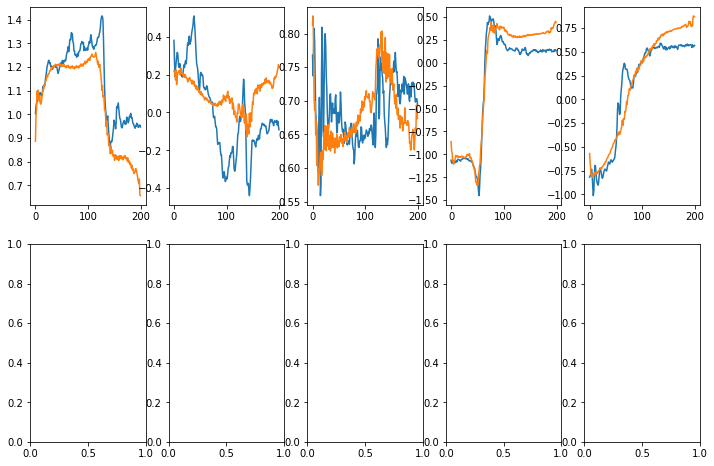

'\nfor i in random.sample(range(0, len(x_data[y_intent==0])), 5):\n    enc = vae.encoder.predict(x_data[y_intent==0][i:i+1])\n    dec = vae.decoder.predict(enc[0])\n    ax[divmod(j,5)].plot(x_data[y_intent==0][i,:,0])\n    ax[divmod(j,5)].plot(dec[0,:,0])\n    \n    j += 1\n\nplt.show()'

In [72]:
import random

fig,ax = plt.subplots(2,5, figsize=(12,8))
j = 0

filtered = x_data[y_intent==1]

for i in random.sample(range(0, len(filtered)), 5):
    enc = vae.encoder.predict(filtered[i:i+1])
    dec = vae.decoder.predict(enc[0])
    ax[divmod(j,5)].plot(filtered[i,:,0])
    ax[divmod(j,5)].plot(dec[0,:,0])
    
    j += 1

plt.show()


"""
for i in random.sample(range(0, len(x_data[y_intent==0])), 5):
    enc = vae.encoder.predict(x_data[y_intent==0][i:i+1])
    dec = vae.decoder.predict(enc[0])
    ax[divmod(j,5)].plot(x_data[y_intent==0][i,:,0])
    ax[divmod(j,5)].plot(dec[0,:,0])
    
    j += 1

plt.show()"""

1/1 [==============================] - 0s 27ms/step


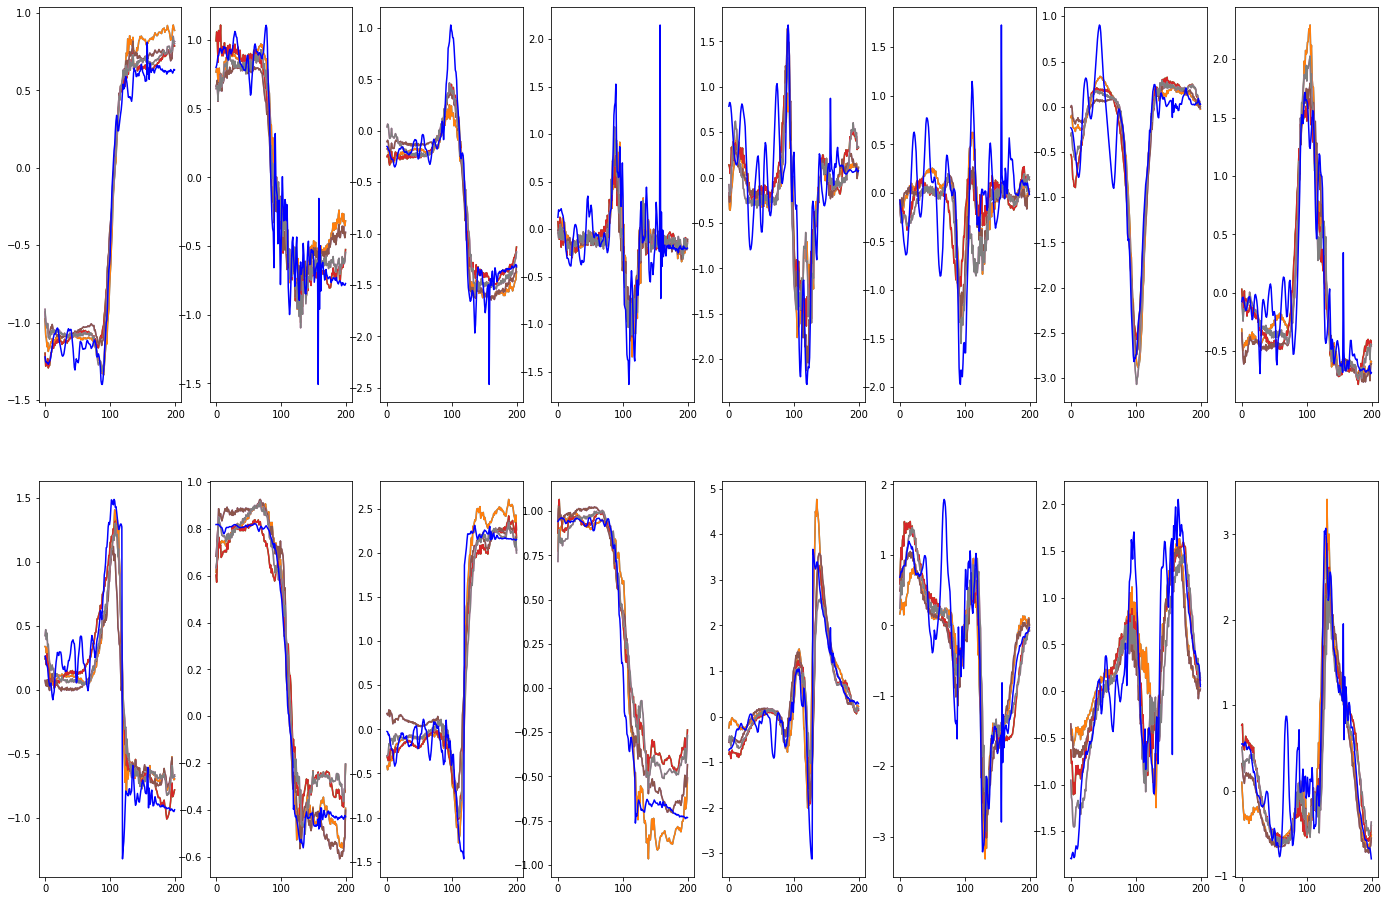

In [73]:
fig,ax = plt.subplots(2,8, figsize=(24,16))

filtered = x_data[y_intent==1]

for i in random.sample(range(0, len(filtered)), 1):
    for k in range(4):
        enc = vae.encoder.predict(filtered[i:i+1])
        dec = vae.decoder.predict(enc[2])
        for j in range(16):
            ax[divmod(j,8)].plot(dec[0,:,j])
            ax[divmod(j,8)].plot(dec[0,:,j])
    for j in range(16):
        ax[divmod(j,8)].plot(filtered[i,:,j], color="blue")
        

plt.show()

1/1 [==============================] - 0s 26ms/step


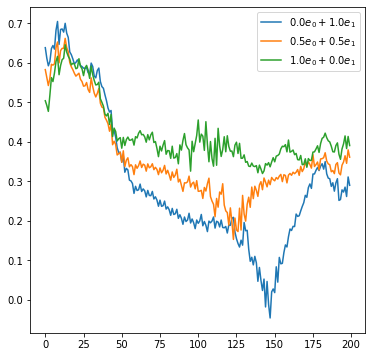

In [74]:
filtered = x_data[y_intent==1]
embeddings = []

plt.figure(figsize=(6,6))

for i in range(1,3):
    
    _, _, enc = vae.encoder.predict(filtered[i:i+1])
    dec = vae.decoder.predict(enc)
    
    embedding = [pca.transform(enc)[0][0], pca.transform(enc)[0][1]]
    embeddings.append(enc)


_n = 2
for j in range(0, _n + 1):
    w1 = j / _n
    w2 = 1 - w1
    
    new_embedding = (embeddings[0] * w1 + embeddings[1] * w2)

    dec = vae.decoder.predict(new_embedding)

    plt.plot(dec[0,:,0], label = f"${round(w1,1)}e_0 + {round(w2,1)}e_1$")


plt.legend()

plt.show()

In [42]:
tf.reduce_mean(abs(classifier(x_data[:1]) - y_intent[:1]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.00034093857>

In [88]:
y_intent[:1]

array([1], dtype=int32)

In [89]:
classifier(x_data[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.6278042e-22]], dtype=float32)>

In [84]:
arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 0)])
arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 1)])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


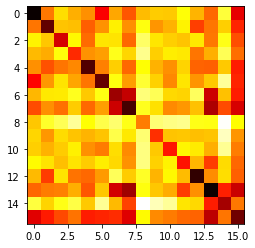

In [131]:
from random import randint

def average_dist(x, y):
    total = 0
    n = 1000
    for u in range(n):
        vx = np.array(x[randint(0, len(x)-1)])
        vy = np.array(y[randint(0, len(y)-1)])
        total += (sum((vx-vy)**2)**0.5)
    return total / n


a = np.zeros((16, 16))




for i in range(16):
    print(i)
    for j in range(i, 16):
        arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == i)])
        arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == j)])
        
        #print(f"User {i} compared to {j} : {average_dist(arr1, arr2)}")
        a[i,j] = average_dist(arr1, arr2)
        a[j,i] = average_dist(arr1, arr2)

plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

#arr1, _, _ = vae.encoder(x_data[(y_intent == 0) & (y_user.argmax(axis=1) == 3)])
#arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 3)])
#average_dist(arr1, arr2)




In [118]:
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

14.229895016786097